In [2]:
import os
import csv
import numpy as np
import tensorflow as tf
import pandas as pd
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from functions import *

open_price = []
volume=[]
split_time = 4000

time_steps=[]
index = 0
with open(r'D:/Downloads/500790.csv') as file:
    csv_reader = csv.reader(file, delimiter=',')
    next(csv_reader)
    #sel_rows = [row for idx, row in enumerate(csv_reader) if idx>2]
    for row in csv_reader:
        index +=1
        time_steps.append(index)
        open_price.append(float(row[1]))# If float not added then order missing in plots as its string
        volume.append(float(row[6]))

In [2]:
time_steps = np.array(time_steps).reshape(-1,1)
open_price = np.array(open_price).reshape(-1,1)
volume = np.array(volume).reshape(-1, 1)
volume = normalize(volume)
open_price = normalize(open_price)
test_open = open_price[split_time:]# Moved here so that EMA are present in this df and this is used only for mae

open_df = pd.DataFrame({'open_price':open_price[:,0]})
#open_df['200dayEMA'] = open_df.ewm(span=200, adjust=False).mean()
open_df['50dayEMA'] = open_df.iloc[:,0].ewm(span=50, adjust=False).mean()
open_df['20dayEMA'] = open_df.iloc[:,0].ewm(span=20, adjust=False).mean()
open_df['short_term'] = open_df['20dayEMA'] - open_df['50dayEMA']
#open_df['long_term'] = open_df['50dayEMA'] - open_df['200dayEMA']
#open_df['long_term'] = normalize(open_df['long_term'])
open_df['short_term'] = normalize(open_df['short_term'])
#open_df = open_df.drop(['200dayEMA','50dayEMA','20dayEMA'], axis=1)

In [3]:
open_price = np.asarray(open_df)
totalVars = open_price.shape[1]
train_volume= volume[:split_time]
train_open = open_price[:split_time]

train_data = np.concatenate([train_open,train_volume],axis=1)
totalVars+=1
window_size = 10
batch_size = 16
shuffle_buffer_size = 1000

train_ds = windowed_dataset(train_data, window_size, batch_size, shuffle_buffer_size)

In [4]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu', padding='causal',input_shape=[None, totalVars]),
    tf.keras.layers.LSTM(128, activation='relu', return_sequences=True),
    tf.keras.layers.LSTM(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(metrics=['mae'], loss=tf.keras.losses.Huber(), optimizer='adam')
history = model.fit(train_ds, epochs=50)
model.save('stockMulti.h5')

#model = tf.keras.models.load_model('stockMulti.h5')

Epoch 1/50
250/250 [==============================] - 3s 8ms/step - loss: 4.1217e-05 - mae: 0.0067
Epoch 2/50
250/250 [==============================] - 2s 7ms/step - loss: 1.8308e-05 - mae: 0.0039
Epoch 3/50
250/250 [==============================] - 2s 7ms/step - loss: 9.0875e-06 - mae: 0.0024
Epoch 4/50
250/250 [==============================] - 2s 7ms/step - loss: 1.3194e-05 - mae: 0.0033
Epoch 5/50
250/250 [==============================] - 2s 7ms/step - loss: 8.3306e-06 - mae: 0.0023
Epoch 6/50
250/250 [==============================] - 2s 7ms/step - loss: 9.0811e-06 - mae: 0.0025
Epoch 7/50
250/250 [==============================] - 2s 8ms/step - loss: 6.9167e-06 - mae: 0.0022
Epoch 8/50
250/250 [==============================] - 2s 8ms/step - loss: 1.0651e-05 - mae: 0.0032
Epoch 9/50
250/250 [==============================] - 2s 8ms/step - loss: 8.7313e-06 - mae: 0.0028
Epoch 10/50
250/250 [==============================] - 2s 8ms/step - loss: 6.6632e-06 - mae: 0.0023
Epoch 11/

In [5]:
rnn_forecast = open_price[:,1][split_time-window_size:split_time]
open_price_ema = open_price[:,1:][split_time-window_size:]
test_volume = volume[split_time - window_size:]
for time in range((len(open_price) - split_time)):
    open_test = rnn_forecast[time:time + window_size].reshape(-1,1)
    vol_test = test_volume[time:time + window_size]
    open_price_ema_test = open_price_ema[time:time + window_size]
    input = np.concatenate([open_test, open_price_ema_test, vol_test],axis=1).reshape(-1,window_size,totalVars)
    pred_out = model.predict(input)
    rnn_forecast = np.append(rnn_forecast, pred_out)
rnn_forecast = rnn_forecast[window_size:].reshape(-1,1)
forecast = np.array(rnn_forecast)[:, 0]

mae = tf.keras.metrics.mae(test_open.reshape(-1),forecast).numpy()
print(mae)

0.03140308831683402


In [11]:
print(mae)

0.011522836297127423


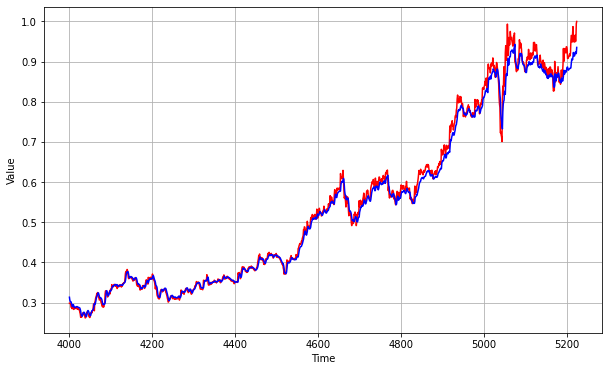

In [13]:
plt.figure(figsize=(10, 6))
plot_series(time_steps[split_time:], test_open, 'r')
plot_series(time_steps[split_time:], forecast, 'b')